In [1]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [2]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [3]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 100
    args.margin_loss = 1.0
    args.border  = 21
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 41
    args.exported = False
    return args

def concatenate_mini_batches_feat_orien(batch_result):
    mini_feat_batch_concat = []
    mini_orien_batch_concat = []
    
    for i, (boxs, mini_feat_batch, mini_orien_batch) in enumerate(batch_result):
        mini_feat_batch_concat.append(mini_feat_batch)
        mini_orien_batch_concat.append(mini_orien_batch)

    mini_feat_batch_concat = torch.cat(mini_feat_batch_concat, dim=0)
    mini_orien_batch_concat = torch.cat(mini_orien_batch_concat, dim=0)

    mini_dataloader = torch.stack([mini_feat_batch_concat, mini_orien_batch_concat], dim=1)

    return mini_dataloader


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 100 loss 3.536601146062214
100 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3])


### Segementa todas as features de batch só

mini_dataloader  torch.Size([4482, 2, 41, 41])


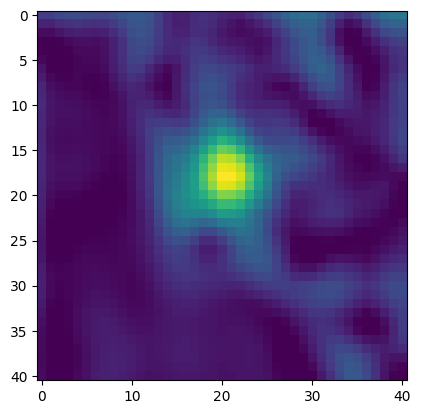

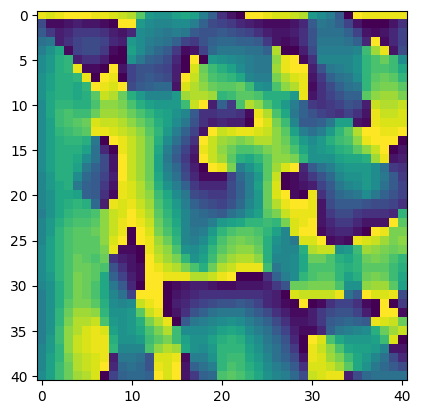

In [4]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

mini_dataloader = concatenate_mini_batches_feat_orien(batch_result)
print('mini_dataloader ',mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [5]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 25

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.6
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


108
72


### Define arquitetura do modelo de rede siamesa

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

In [7]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=2).to(device)
        x = mask(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        # self.dense1 = nn.Linear(2*1*625, 512)
        self.dense1 = nn.Linear(2*1*1225, 512)
        self.dense2 = nn.Linear(512, 128)
        self.droupout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU()
        #self.activation = nn.ELU()
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation2 = nn.Tanh()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        # x = self.dense1(x)
        # x = self.dense2(x)
               
        x = self.droupout(self.dense1(x))
        x = self.activation(x)
        x = self.droupout(self.dense2(x))
        x = self.activation(x)
        
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x

# class Discriminator(nn.Module):
#     def __init__(self, n_classes=10):
#         super().__init__()

#         self.block_1 = nn.Sequential(
#             nn.Linear(1225, 512),
#             nn.Dropout(0.2),
#             nn.LeakyReLU()
#         )
        
#         self.block_2 = nn.Sequential(
#             nn.Linear(512, 128),
#             nn.Dropout(0.2),
#             nn.LeakyReLU()
#         )

#         self.activation = nn.LeakyReLU()

#     def forward(self, X1, X2):
#         flatten_x1 = X1.view(X1.size(0), -1)
#         flatten_x2 = X2.view(X2.size(0), -1)

#         x1 = self.block_1(flatten_x1)
#         x1 = self.block_2(x1)
        
#         x2 = self.block_1(flatten_x2)
#         x2 = self.block_2(x2)
        
#         diff = torch.abs(x1 - x2)
#         output = torch.norm(diff, dim=1)
#         output = self.activation(output)
#         return output
    
class Siamesa(nn.Module):
    def __init__(self,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x


### Metodos para o processo de treinamento

In [8]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = args.margin_loss
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10)(x)
    return x


In [9]:
model =Siamesa(n_channel=2).to(device)
X1=torch.rand(8,2,41,41).to(device)
X2=torch.rand(8,2,41,41).to(device)

dist = model(X1,X2)
dist

tensor([4.2461, 3.4325, 3.3847, 3.2188, 3.8961, 4.2411, 3.7597, 4.5595],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)

In [10]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model, train_loader, test_loader, loss_fn, epochs=10, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)

    best_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(epochs):
        loss_train = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        loss_test = test(model, test_loader, loss_fn, device)

        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')

        # Verificar se a perda melhorou
        if loss_test < best_loss:
            best_loss = loss_test
            epochs_without_improvement = 0
            # Salvar o estado do modelo
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1

        # Verificar a condição de parada
        if epochs_without_improvement == 50:
            print(f"No improvement in loss for {epochs_without_improvement} epochs. Training stopped.")
            break

        # Atualizar a taxa de aprendizado
        if (epoch % 10 == 0) and (epoch != 0):
            scheduler.step()

        print('initial_lr:', optimizer.param_groups[0]['initial_lr'], 'lr:', optimizer.param_groups[0]['lr'],' epochs_without_improvement ',epochs_without_improvement)

    # Carregar a melhor configuração do modelo
    model.load_state_dict(best_model)
    print(f'Epoch: {epoch}, Best Loss: {best_loss:.4f}')
    

train(model,train_loader,test_loader,loss_fn,epochs=300
      ,device=device)

Tests : 100%|██████████| 72/72 [00:05<00:00, 12.50it/s]


Epoch: 0, Train Loss: 1.2810, Test Loss: 0.9798
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.17it/s]


Epoch: 1, Train Loss: 0.8079, Test Loss: 0.7020
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.39it/s]


Epoch: 2, Train Loss: 0.4825, Test Loss: 0.3291
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.58it/s]


Epoch: 3, Train Loss: 0.3349, Test Loss: 0.2854
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.57it/s]


Epoch: 4, Train Loss: 0.2624, Test Loss: 0.1990
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 5, Train Loss: 0.2151, Test Loss: 0.1168
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.23it/s]


Epoch: 6, Train Loss: 0.1520, Test Loss: 0.0700
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 7, Train Loss: 0.1104, Test Loss: 0.0604
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.52it/s]


Epoch: 8, Train Loss: 0.0941, Test Loss: 0.0675
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.58it/s]


Epoch: 9, Train Loss: 0.0886, Test Loss: 0.0469
initial_lr: 0.001 lr: 0.001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 10, Train Loss: 0.0622, Test Loss: 0.0584
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.16it/s]


Epoch: 11, Train Loss: 0.0584, Test Loss: 0.0394
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 12, Train Loss: 0.0640, Test Loss: 0.0306
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 13, Train Loss: 0.0528, Test Loss: 0.0558
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.84it/s]


Epoch: 14, Train Loss: 0.0599, Test Loss: 0.0628
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.62it/s]


Epoch: 15, Train Loss: 0.0510, Test Loss: 0.0414
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.30it/s]


Epoch: 16, Train Loss: 0.0532, Test Loss: 0.0438
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.65it/s]


Epoch: 17, Train Loss: 0.0495, Test Loss: 0.0397
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Epoch: 18, Train Loss: 0.0569, Test Loss: 0.0297
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.66it/s]


Epoch: 19, Train Loss: 0.0507, Test Loss: 0.0329
initial_lr: 0.001 lr: 0.00075  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.43it/s]


Epoch: 20, Train Loss: 0.0623, Test Loss: 0.0475
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 21, Train Loss: 0.0615, Test Loss: 0.0345
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.60it/s]


Epoch: 22, Train Loss: 0.0400, Test Loss: 0.0440
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.46it/s]


Epoch: 23, Train Loss: 0.0628, Test Loss: 0.0330
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.70it/s]


Epoch: 24, Train Loss: 0.0530, Test Loss: 0.0278
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.24it/s]


Epoch: 25, Train Loss: 0.0496, Test Loss: 0.0358
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 26, Train Loss: 0.0459, Test Loss: 0.0367
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.65it/s]


Epoch: 27, Train Loss: 0.0463, Test Loss: 0.0339
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.21it/s]


Epoch: 28, Train Loss: 0.0332, Test Loss: 0.0294
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.87it/s]


Epoch: 29, Train Loss: 0.0541, Test Loss: 0.0395
initial_lr: 0.001 lr: 0.0005625000000000001  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.92it/s]


Epoch: 30, Train Loss: 0.0380, Test Loss: 0.0308
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 31, Train Loss: 0.0526, Test Loss: 0.0348
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.81it/s]


Epoch: 32, Train Loss: 0.0444, Test Loss: 0.0328
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.94it/s]


Epoch: 33, Train Loss: 0.0415, Test Loss: 0.0298
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.44it/s]


Epoch: 34, Train Loss: 0.0451, Test Loss: 0.0216
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.87it/s]


Epoch: 35, Train Loss: 0.0286, Test Loss: 0.0337
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.87it/s]


Epoch: 36, Train Loss: 0.0366, Test Loss: 0.0325
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 37, Train Loss: 0.0306, Test Loss: 0.0322
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.93it/s]


Epoch: 38, Train Loss: 0.0445, Test Loss: 0.0315
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.94it/s]


Epoch: 39, Train Loss: 0.0476, Test Loss: 0.0292
initial_lr: 0.001 lr: 0.00042187500000000005  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.47it/s]


Epoch: 40, Train Loss: 0.0548, Test Loss: 0.0360
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.84it/s]


Epoch: 41, Train Loss: 0.0410, Test Loss: 0.0295
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.87it/s]


Epoch: 42, Train Loss: 0.0334, Test Loss: 0.0233
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.45it/s]


Epoch: 43, Train Loss: 0.0388, Test Loss: 0.0376
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.95it/s]


Epoch: 44, Train Loss: 0.0356, Test Loss: 0.0227
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.84it/s]


Epoch: 45, Train Loss: 0.0439, Test Loss: 0.0181
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.58it/s]


Epoch: 46, Train Loss: 0.0497, Test Loss: 0.0360
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.78it/s]


Epoch: 47, Train Loss: 0.0439, Test Loss: 0.0216
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.91it/s]


Epoch: 48, Train Loss: 0.0378, Test Loss: 0.0280
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 49, Train Loss: 0.0386, Test Loss: 0.0215
initial_lr: 0.001 lr: 0.00031640625000000006  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.89it/s]


Epoch: 50, Train Loss: 0.0322, Test Loss: 0.0284
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.90it/s]


Epoch: 51, Train Loss: 0.0310, Test Loss: 0.0272
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 52, Train Loss: 0.0466, Test Loss: 0.0221
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.79it/s]


Epoch: 53, Train Loss: 0.0369, Test Loss: 0.0361
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.84it/s]


Epoch: 54, Train Loss: 0.0307, Test Loss: 0.0195
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 55, Train Loss: 0.0274, Test Loss: 0.0328
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.79it/s]


Epoch: 56, Train Loss: 0.0370, Test Loss: 0.0261
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:05<00:00, 13.00it/s]


Epoch: 57, Train Loss: 0.0223, Test Loss: 0.0246
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.44it/s]


Epoch: 58, Train Loss: 0.0274, Test Loss: 0.0240
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.92it/s]


Epoch: 59, Train Loss: 0.0323, Test Loss: 0.0241
initial_lr: 0.001 lr: 0.00023730468750000005  epochs_without_improvement  14


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.93it/s]


Epoch: 60, Train Loss: 0.0297, Test Loss: 0.0151
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 61, Train Loss: 0.0315, Test Loss: 0.0299
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.84it/s]


Epoch: 62, Train Loss: 0.0307, Test Loss: 0.0259
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.86it/s]


Epoch: 63, Train Loss: 0.0281, Test Loss: 0.0277
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.33it/s]


Epoch: 64, Train Loss: 0.0282, Test Loss: 0.0266
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.83it/s]


Epoch: 65, Train Loss: 0.0284, Test Loss: 0.0193
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.51it/s]


Epoch: 66, Train Loss: 0.0286, Test Loss: 0.0305
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.17it/s]


Epoch: 67, Train Loss: 0.0311, Test Loss: 0.0255
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.45it/s]


Epoch: 68, Train Loss: 0.0242, Test Loss: 0.0181
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.26it/s]


Epoch: 69, Train Loss: 0.0351, Test Loss: 0.0247
initial_lr: 0.001 lr: 0.00017797851562500002  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.69it/s]


Epoch: 70, Train Loss: 0.0257, Test Loss: 0.0239
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.00it/s]


Epoch: 71, Train Loss: 0.0292, Test Loss: 0.0218
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.01it/s]


Epoch: 72, Train Loss: 0.0224, Test Loss: 0.0216
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 73, Train Loss: 0.0346, Test Loss: 0.0229
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 74, Train Loss: 0.0328, Test Loss: 0.0138
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.54it/s]


Epoch: 75, Train Loss: 0.0354, Test Loss: 0.0224
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.68it/s]


Epoch: 76, Train Loss: 0.0226, Test Loss: 0.0248
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.66it/s]


Epoch: 77, Train Loss: 0.0224, Test Loss: 0.0256
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.20it/s]


Epoch: 78, Train Loss: 0.0226, Test Loss: 0.0280
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.42it/s]


Epoch: 79, Train Loss: 0.0206, Test Loss: 0.0207
initial_lr: 0.001 lr: 0.00013348388671875002  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Epoch: 80, Train Loss: 0.0213, Test Loss: 0.0241
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.12it/s]


Epoch: 81, Train Loss: 0.0224, Test Loss: 0.0202
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.21it/s]


Epoch: 82, Train Loss: 0.0221, Test Loss: 0.0194
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.58it/s]


Epoch: 83, Train Loss: 0.0268, Test Loss: 0.0278
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.07it/s]


Epoch: 84, Train Loss: 0.0175, Test Loss: 0.0144
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.39it/s]


Epoch: 85, Train Loss: 0.0230, Test Loss: 0.0187
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.39it/s]


Epoch: 86, Train Loss: 0.0279, Test Loss: 0.0241
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.67it/s]


Epoch: 87, Train Loss: 0.0182, Test Loss: 0.0241
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 88, Train Loss: 0.0319, Test Loss: 0.0152
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  14


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 89, Train Loss: 0.0329, Test Loss: 0.0203
initial_lr: 0.001 lr: 0.00010011291503906251  epochs_without_improvement  15


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.46it/s]


Epoch: 90, Train Loss: 0.0293, Test Loss: 0.0118
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.96it/s]


Epoch: 91, Train Loss: 0.0229, Test Loss: 0.0163
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.80it/s]


Epoch: 92, Train Loss: 0.0238, Test Loss: 0.0147
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.19it/s]


Epoch: 93, Train Loss: 0.0291, Test Loss: 0.0227
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.46it/s]


Epoch: 94, Train Loss: 0.0319, Test Loss: 0.0134
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.24it/s]


Epoch: 95, Train Loss: 0.0278, Test Loss: 0.0186
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.54it/s]


Epoch: 96, Train Loss: 0.0236, Test Loss: 0.0134
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.57it/s]


Epoch: 97, Train Loss: 0.0227, Test Loss: 0.0205
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.64it/s]


Epoch: 98, Train Loss: 0.0254, Test Loss: 0.0184
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.41it/s]


Epoch: 99, Train Loss: 0.0226, Test Loss: 0.0172
initial_lr: 0.001 lr: 7.508468627929689e-05  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.50it/s]


Epoch: 100, Train Loss: 0.0225, Test Loss: 0.0117
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 101, Train Loss: 0.0244, Test Loss: 0.0140
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.07it/s]


Epoch: 102, Train Loss: 0.0304, Test Loss: 0.0153
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.24it/s]


Epoch: 103, Train Loss: 0.0197, Test Loss: 0.0226
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.35it/s]


Epoch: 104, Train Loss: 0.0216, Test Loss: 0.0175
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.29it/s]


Epoch: 105, Train Loss: 0.0207, Test Loss: 0.0149
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.36it/s]


Epoch: 106, Train Loss: 0.0227, Test Loss: 0.0113
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.39it/s]


Epoch: 107, Train Loss: 0.0103, Test Loss: 0.0184
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.05it/s]


Epoch: 108, Train Loss: 0.0254, Test Loss: 0.0222
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.45it/s]


Epoch: 109, Train Loss: 0.0198, Test Loss: 0.0219
initial_lr: 0.001 lr: 5.631351470947266e-05  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.18it/s]


Epoch: 110, Train Loss: 0.0135, Test Loss: 0.0253
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.47it/s]


Epoch: 111, Train Loss: 0.0220, Test Loss: 0.0236
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.66it/s]


Epoch: 112, Train Loss: 0.0228, Test Loss: 0.0124
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.65it/s]


Epoch: 113, Train Loss: 0.0196, Test Loss: 0.0111
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.91it/s]


Epoch: 114, Train Loss: 0.0215, Test Loss: 0.0180
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.11it/s]


Epoch: 115, Train Loss: 0.0214, Test Loss: 0.0236
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.51it/s]


Epoch: 116, Train Loss: 0.0252, Test Loss: 0.0106
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.52it/s]


Epoch: 117, Train Loss: 0.0177, Test Loss: 0.0207
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.19it/s]


Epoch: 118, Train Loss: 0.0197, Test Loss: 0.0216
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.98it/s]


Epoch: 119, Train Loss: 0.0183, Test Loss: 0.0174
initial_lr: 0.001 lr: 4.22351360321045e-05  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.75it/s]


Epoch: 120, Train Loss: 0.0191, Test Loss: 0.0151
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.19it/s]


Epoch: 121, Train Loss: 0.0191, Test Loss: 0.0164
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.43it/s]


Epoch: 122, Train Loss: 0.0228, Test Loss: 0.0220
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 123, Train Loss: 0.0196, Test Loss: 0.0173
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.41it/s]


Epoch: 124, Train Loss: 0.0128, Test Loss: 0.0226
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.04it/s]


Epoch: 125, Train Loss: 0.0209, Test Loss: 0.0136
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 126, Train Loss: 0.0149, Test Loss: 0.0158
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 127, Train Loss: 0.0245, Test Loss: 0.0242
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.39it/s]


Epoch: 128, Train Loss: 0.0215, Test Loss: 0.0226
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.64it/s]


Epoch: 129, Train Loss: 0.0215, Test Loss: 0.0165
initial_lr: 0.001 lr: 3.167635202407837e-05  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 130, Train Loss: 0.0166, Test Loss: 0.0201
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  14


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.58it/s]


Epoch: 131, Train Loss: 0.0308, Test Loss: 0.0171
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  15


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 132, Train Loss: 0.0150, Test Loss: 0.0169
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  16


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.14it/s]


Epoch: 133, Train Loss: 0.0155, Test Loss: 0.0193
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  17


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.54it/s]


Epoch: 134, Train Loss: 0.0204, Test Loss: 0.0099
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.32it/s]


Epoch: 135, Train Loss: 0.0177, Test Loss: 0.0129
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.54it/s]


Epoch: 136, Train Loss: 0.0171, Test Loss: 0.0159
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.74it/s]


Epoch: 137, Train Loss: 0.0254, Test Loss: 0.0233
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.61it/s]


Epoch: 138, Train Loss: 0.0241, Test Loss: 0.0145
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.51it/s]


Epoch: 139, Train Loss: 0.0132, Test Loss: 0.0163
initial_lr: 0.001 lr: 2.3757264018058778e-05  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.34it/s]


Epoch: 140, Train Loss: 0.0250, Test Loss: 0.0188
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.67it/s]


Epoch: 141, Train Loss: 0.0197, Test Loss: 0.0136
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.78it/s]


Epoch: 142, Train Loss: 0.0219, Test Loss: 0.0159
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.64it/s]


Epoch: 143, Train Loss: 0.0218, Test Loss: 0.0181
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.31it/s]


Epoch: 144, Train Loss: 0.0204, Test Loss: 0.0208
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.75it/s]


Epoch: 145, Train Loss: 0.0190, Test Loss: 0.0197
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.77it/s]


Epoch: 146, Train Loss: 0.0192, Test Loss: 0.0154
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.42it/s]


Epoch: 147, Train Loss: 0.0140, Test Loss: 0.0234
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.69it/s]


Epoch: 148, Train Loss: 0.0191, Test Loss: 0.0377
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  14


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.75it/s]


Epoch: 149, Train Loss: 0.0135, Test Loss: 0.0119
initial_lr: 0.001 lr: 1.7817948013544083e-05  epochs_without_improvement  15


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.35it/s]


Epoch: 150, Train Loss: 0.0310, Test Loss: 0.0141
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  16


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.76it/s]


Epoch: 151, Train Loss: 0.0169, Test Loss: 0.0097
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.71it/s]


Epoch: 152, Train Loss: 0.0213, Test Loss: 0.0261
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.33it/s]


Epoch: 153, Train Loss: 0.0221, Test Loss: 0.0166
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.66it/s]


Epoch: 154, Train Loss: 0.0202, Test Loss: 0.0140
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.69it/s]


Epoch: 155, Train Loss: 0.0240, Test Loss: 0.0168
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.39it/s]


Epoch: 156, Train Loss: 0.0170, Test Loss: 0.0183
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.95it/s]


Epoch: 157, Train Loss: 0.0172, Test Loss: 0.0104
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.44it/s]


Epoch: 158, Train Loss: 0.0185, Test Loss: 0.0115
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.13it/s]


Epoch: 159, Train Loss: 0.0164, Test Loss: 0.0159
initial_lr: 0.001 lr: 1.3363461010158061e-05  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.52it/s]


Epoch: 160, Train Loss: 0.0153, Test Loss: 0.0135
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.32it/s]


Epoch: 161, Train Loss: 0.0137, Test Loss: 0.0128
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 162, Train Loss: 0.0208, Test Loss: 0.0212
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.69it/s]


Epoch: 163, Train Loss: 0.0145, Test Loss: 0.0097
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.27it/s]


Epoch: 164, Train Loss: 0.0250, Test Loss: 0.0191
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Epoch: 165, Train Loss: 0.0176, Test Loss: 0.0191
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  14


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.50it/s]


Epoch: 166, Train Loss: 0.0207, Test Loss: 0.0158
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  15


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.52it/s]


Epoch: 167, Train Loss: 0.0179, Test Loss: 0.0195
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  16


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.70it/s]


Epoch: 168, Train Loss: 0.0150, Test Loss: 0.0115
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  17


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.37it/s]


Epoch: 169, Train Loss: 0.0265, Test Loss: 0.0222
initial_lr: 0.001 lr: 1.0022595757618546e-05  epochs_without_improvement  18


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.66it/s]


Epoch: 170, Train Loss: 0.0231, Test Loss: 0.0119
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  19


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.59it/s]


Epoch: 171, Train Loss: 0.0203, Test Loss: 0.0188
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  20


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.03it/s]


Epoch: 172, Train Loss: 0.0186, Test Loss: 0.0202
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  21


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.66it/s]


Epoch: 173, Train Loss: 0.0234, Test Loss: 0.0212
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  22


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.59it/s]


Epoch: 174, Train Loss: 0.0165, Test Loss: 0.0194
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  23


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 175, Train Loss: 0.0153, Test Loss: 0.0131
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  24


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.57it/s]


Epoch: 176, Train Loss: 0.0213, Test Loss: 0.0173
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  25


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.32it/s]


Epoch: 177, Train Loss: 0.0193, Test Loss: 0.0201
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  26


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 178, Train Loss: 0.0200, Test Loss: 0.0165
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  27


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.54it/s]


Epoch: 179, Train Loss: 0.0166, Test Loss: 0.0146
initial_lr: 0.001 lr: 7.51694681821391e-06  epochs_without_improvement  28


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.15it/s]


Epoch: 180, Train Loss: 0.0153, Test Loss: 0.0142
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  29


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.51it/s]


Epoch: 181, Train Loss: 0.0158, Test Loss: 0.0183
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  30


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.15it/s]


Epoch: 182, Train Loss: 0.0102, Test Loss: 0.0171
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  31


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.19it/s]


Epoch: 183, Train Loss: 0.0189, Test Loss: 0.0129
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  32


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.60it/s]


Epoch: 184, Train Loss: 0.0221, Test Loss: 0.0139
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  33


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.60it/s]


Epoch: 185, Train Loss: 0.0219, Test Loss: 0.0260
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  34


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.45it/s]


Epoch: 186, Train Loss: 0.0239, Test Loss: 0.0148
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  35


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.31it/s]


Epoch: 187, Train Loss: 0.0218, Test Loss: 0.0192
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  36


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Epoch: 188, Train Loss: 0.0182, Test Loss: 0.0147
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  37


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.63it/s]


Epoch: 189, Train Loss: 0.0139, Test Loss: 0.0155
initial_lr: 0.001 lr: 5.637710113660432e-06  epochs_without_improvement  38


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.20it/s]


Epoch: 190, Train Loss: 0.0163, Test Loss: 0.0152
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  39


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.60it/s]


Epoch: 191, Train Loss: 0.0187, Test Loss: 0.0136
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  40


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.16it/s]


Epoch: 192, Train Loss: 0.0192, Test Loss: 0.0162
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  41


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.18it/s]


Epoch: 193, Train Loss: 0.0228, Test Loss: 0.0204
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  42


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.57it/s]


Epoch: 194, Train Loss: 0.0203, Test Loss: 0.0118
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  43


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.58it/s]


Epoch: 195, Train Loss: 0.0179, Test Loss: 0.0164
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  44


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.55it/s]


Epoch: 196, Train Loss: 0.0270, Test Loss: 0.0134
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  45


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.20it/s]


Epoch: 197, Train Loss: 0.0143, Test Loss: 0.0063
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  0


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.35it/s]


Epoch: 198, Train Loss: 0.0165, Test Loss: 0.0195
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  1


Tests : 100%|██████████| 72/72 [00:06<00:00, 11.93it/s]


Epoch: 199, Train Loss: 0.0261, Test Loss: 0.0166
initial_lr: 0.001 lr: 4.228282585245324e-06  epochs_without_improvement  2


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.37it/s]


Epoch: 200, Train Loss: 0.0143, Test Loss: 0.0154
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  3


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.55it/s]


Epoch: 201, Train Loss: 0.0166, Test Loss: 0.0147
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  4


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.27it/s]


Epoch: 202, Train Loss: 0.0197, Test Loss: 0.0170
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  5


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.51it/s]


Epoch: 203, Train Loss: 0.0234, Test Loss: 0.0212
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  6


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.42it/s]


Epoch: 204, Train Loss: 0.0188, Test Loss: 0.0087
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  7


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.40it/s]


Epoch: 205, Train Loss: 0.0196, Test Loss: 0.0110
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  8


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.40it/s]


Epoch: 206, Train Loss: 0.0193, Test Loss: 0.0244
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  9


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.20it/s]


Epoch: 207, Train Loss: 0.0207, Test Loss: 0.0280
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  10


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Epoch: 208, Train Loss: 0.0132, Test Loss: 0.0148
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  11


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 209, Train Loss: 0.0134, Test Loss: 0.0183
initial_lr: 0.001 lr: 3.171211938933993e-06  epochs_without_improvement  12


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.27it/s]


Epoch: 210, Train Loss: 0.0288, Test Loss: 0.0121
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  13


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Epoch: 211, Train Loss: 0.0169, Test Loss: 0.0238
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  14


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.08it/s]


Epoch: 212, Train Loss: 0.0181, Test Loss: 0.0154
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  15


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.24it/s]


Epoch: 213, Train Loss: 0.0188, Test Loss: 0.0163
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  16


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.30it/s]


Epoch: 214, Train Loss: 0.0169, Test Loss: 0.0133
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  17


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.51it/s]


Epoch: 215, Train Loss: 0.0184, Test Loss: 0.0184
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  18


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.32it/s]


Epoch: 216, Train Loss: 0.0181, Test Loss: 0.0157
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  19


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.55it/s]


Epoch: 217, Train Loss: 0.0345, Test Loss: 0.0123
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  20


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.63it/s]


Epoch: 218, Train Loss: 0.0165, Test Loss: 0.0218
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  21


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 219, Train Loss: 0.0195, Test Loss: 0.0179
initial_lr: 0.001 lr: 2.3784089542004944e-06  epochs_without_improvement  22


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.24it/s]


Epoch: 220, Train Loss: 0.0165, Test Loss: 0.0245
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  23


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.37it/s]


Epoch: 221, Train Loss: 0.0255, Test Loss: 0.0141
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  24


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.50it/s]


Epoch: 222, Train Loss: 0.0209, Test Loss: 0.0205
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  25


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.56it/s]


Epoch: 223, Train Loss: 0.0142, Test Loss: 0.0173
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  26


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.62it/s]


Epoch: 224, Train Loss: 0.0174, Test Loss: 0.0177
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  27


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.11it/s]


Epoch: 225, Train Loss: 0.0162, Test Loss: 0.0192
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  28


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.51it/s]


Epoch: 226, Train Loss: 0.0202, Test Loss: 0.0139
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  29


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.06it/s]


Epoch: 227, Train Loss: 0.0203, Test Loss: 0.0185
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  30


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.16it/s]


Epoch: 228, Train Loss: 0.0244, Test Loss: 0.0072
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  31


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.32it/s]


Epoch: 229, Train Loss: 0.0175, Test Loss: 0.0073
initial_lr: 0.001 lr: 1.7838067156503708e-06  epochs_without_improvement  32


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 230, Train Loss: 0.0205, Test Loss: 0.0312
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  33


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.14it/s]


Epoch: 231, Train Loss: 0.0235, Test Loss: 0.0107
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  34


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.52it/s]


Epoch: 232, Train Loss: 0.0132, Test Loss: 0.0112
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  35


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 233, Train Loss: 0.0215, Test Loss: 0.0166
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  36


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


Epoch: 234, Train Loss: 0.0172, Test Loss: 0.0100
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  37


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 235, Train Loss: 0.0269, Test Loss: 0.0208
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  38


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.49it/s]


Epoch: 236, Train Loss: 0.0202, Test Loss: 0.0189
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  39


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.64it/s]


Epoch: 237, Train Loss: 0.0178, Test Loss: 0.0206
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  40


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.32it/s]


Epoch: 238, Train Loss: 0.0182, Test Loss: 0.0096
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  41


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.63it/s]


Epoch: 239, Train Loss: 0.0181, Test Loss: 0.0142
initial_lr: 0.001 lr: 1.337855036737778e-06  epochs_without_improvement  42


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 240, Train Loss: 0.0163, Test Loss: 0.0117
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  43


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.27it/s]


Epoch: 241, Train Loss: 0.0190, Test Loss: 0.0123
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  44


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.18it/s]


Epoch: 242, Train Loss: 0.0192, Test Loss: 0.0167
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  45


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.46it/s]


Epoch: 243, Train Loss: 0.0152, Test Loss: 0.0150
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  46


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.29it/s]


Epoch: 244, Train Loss: 0.0199, Test Loss: 0.0229
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  47


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.12it/s]


Epoch: 245, Train Loss: 0.0200, Test Loss: 0.0203
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  48


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.48it/s]


Epoch: 246, Train Loss: 0.0168, Test Loss: 0.0197
initial_lr: 0.001 lr: 1.0033912775533336e-06  epochs_without_improvement  49


Tests : 100%|██████████| 72/72 [00:05<00:00, 12.29it/s]

Epoch: 247, Train Loss: 0.0233, Test Loss: 0.0240
No improvement in loss for 50 epochs. Training stopped.
Epoch: 247, Best Loss: 0.0063


In [11]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = '.\data\models\siamese_model.pth'
# save_model(model,path_siamese)
save_model(model,path_siamese)
model = Siamesa(n_channel=2).to(device)
load_model(model,path_siamese)



Model saved to .\data\models\siamese_model.pth
Model loaded from .\data\models\siamese_model.pth


### Teste com a rede siamesa

In [12]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [13]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


torch.Size([25, 2, 41, 41])


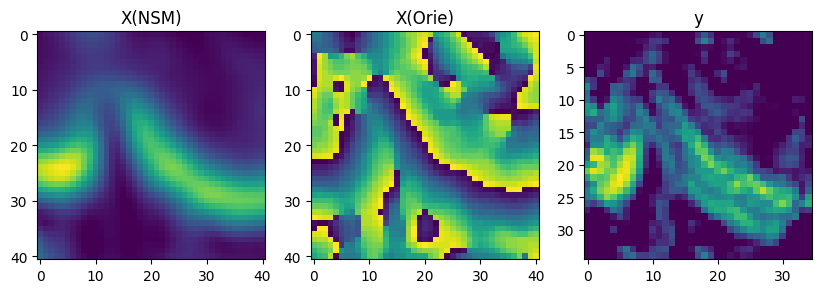

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3016, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3283, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.4013, device='cuda:0') tensor(0.8012, device='cuda:0')


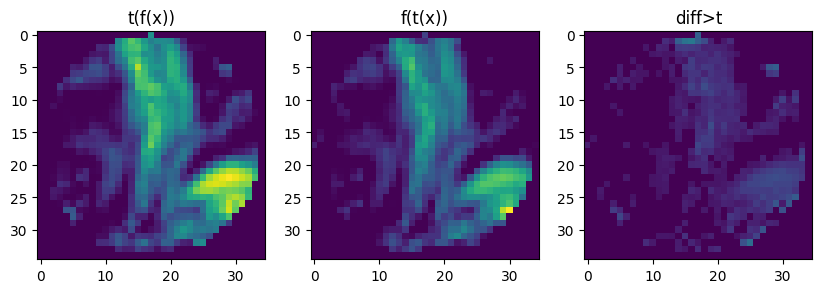

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3401, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3244, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3244, device='cuda:0') tensor(0.4136, device='cuda:0')


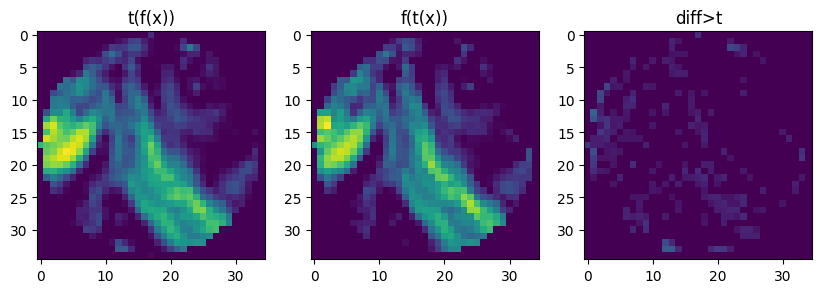

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3503, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3377, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3960, device='cuda:0') tensor(0.5699, device='cuda:0')


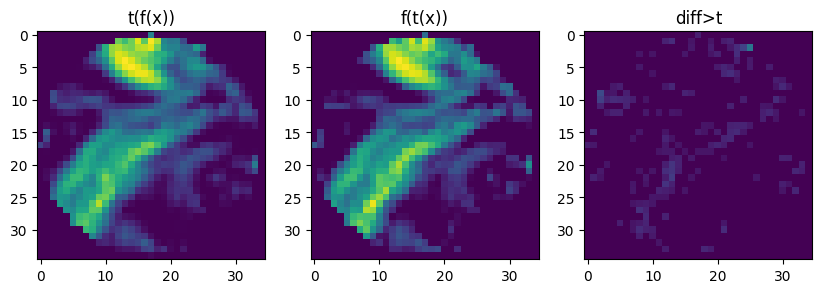

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3070, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3348, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3688, device='cuda:0') tensor(0.4699, device='cuda:0')


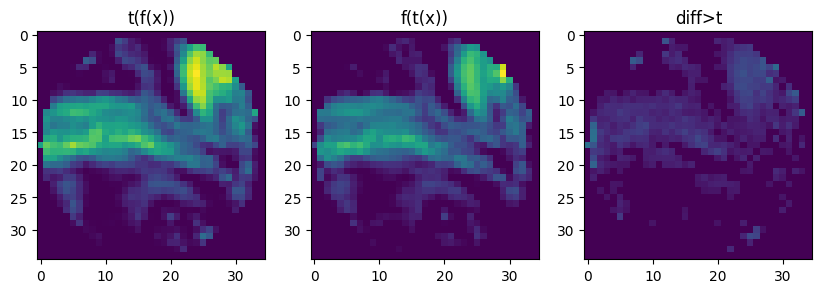

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3167, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3378, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.4961, device='cuda:0') tensor(0.8299, device='cuda:0')


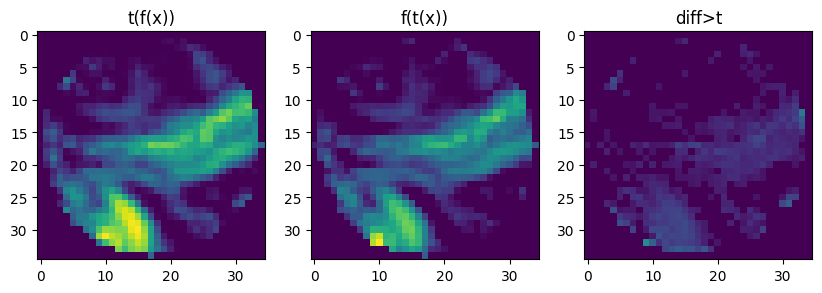

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3167, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3378, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.4961, device='cuda:0') tensor(0.8299, device='cuda:0')


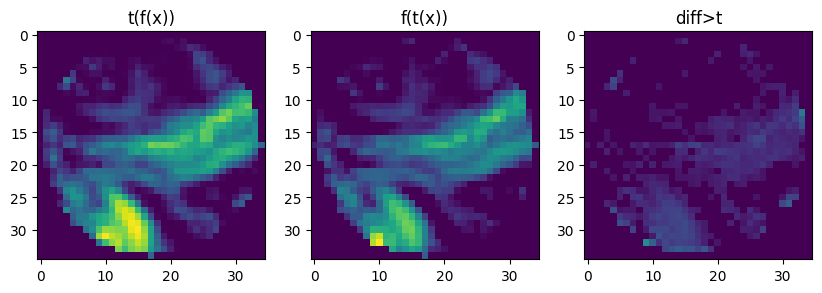

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3184, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3243, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.4870, device='cuda:0') tensor(0.6635, device='cuda:0')


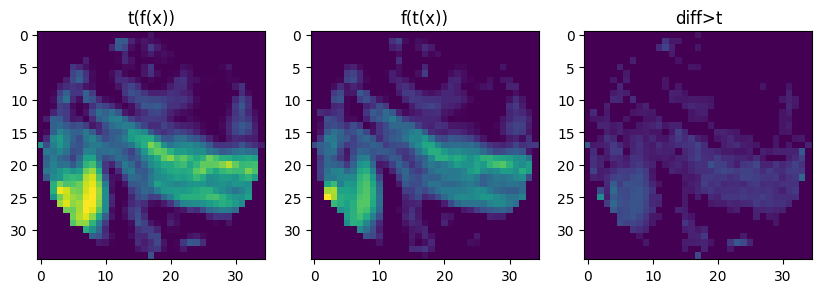

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3030, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3235, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3900, device='cuda:0') tensor(0.2737, device='cuda:0')


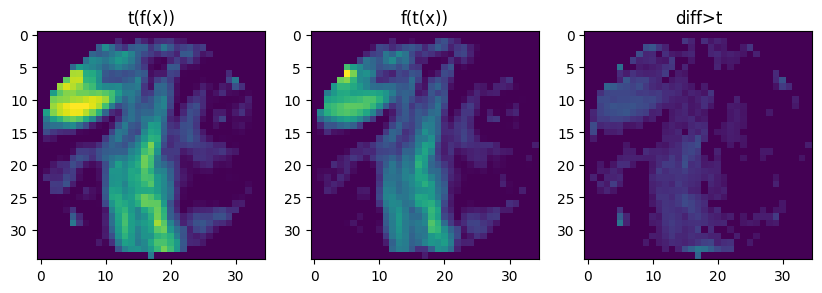

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3063, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3326, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.4683, device='cuda:0') tensor(0.5117, device='cuda:0')


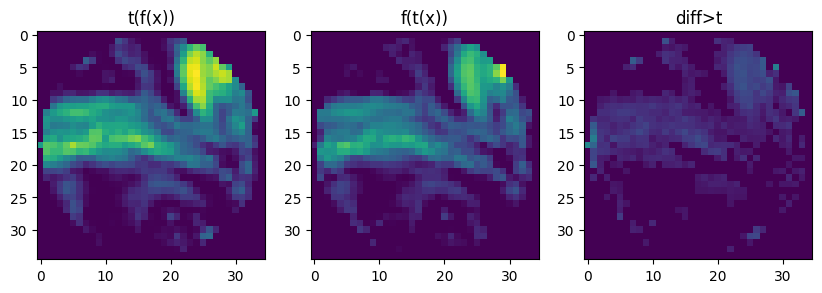

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3423, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.3274, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3019, device='cuda:0') tensor(0.8258, device='cuda:0')


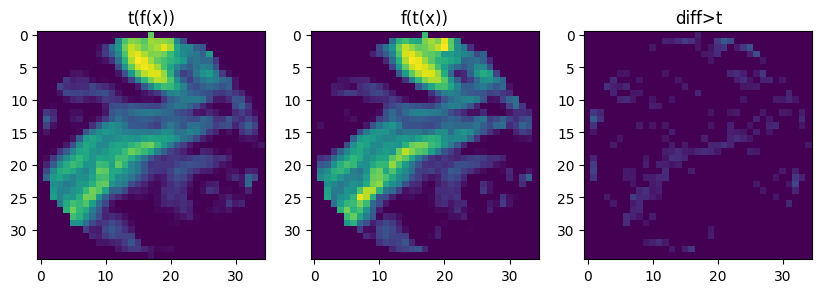

In [14]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)


iterator=iter(test_loader)
data = next(iterator)
print(data.shape)
index = 5
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[index,0])
        y2n=normalize_tensor(y_rotated2[index,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[index])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [28]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

def matching_single_points(data1, data2, apply_random_transform=False):
    size = len(data1)
    matches = []

    with torch.no_grad():
        for i in range(len(data2)):
            img_temp = data2[i][None]

            if apply_random_transform:
                img_temp2 = random_transform(img_temp)
            else:
                img_temp2 = img_temp.clone()

            data_temp = copy_tensor(img_temp2, size)
            if apply_random_transform:
                data_temp = random_transform(data_temp)

            distances = model(data1, data_temp)
            match_index = distances.argmin().item()
            matches.append((i, match_index))
    print(matches)
    return np.array(matches)

            

def matching_single_points_all_dataloader(test_loader, apply_random_transform=False):
    total_acertos = 0
    total =0
    for data in test_loader:
        data1 = data
        data2 = data.clone()
        size = len(data1)
        matches = []
        with torch.no_grad():
            for i in range(len(data2)):
                img_temp = data2[i][None]

                if apply_random_transform:
                    img_temp = random_transform(img_temp)


                data_temp = copy_tensor(img_temp, size)

                distances = model(data1, data_temp)
                match_index = distances.argmin().item()
                matches.append((i, match_index))
                # print(i,distances)
            print(matches)
            matches = np.array(matches)
            total_acertos += np.sum(matches[:, 0] == matches[:, 1])
            total += len(matches)
            print(total_acertos,total)
    return total_acertos,total


total_acertos,total = matching_single_points_all_dataloader(test_loader, apply_random_transform=True)
print(total_acertos,total,total_acertos/total)


# for (i,j) in matching_results[:10]:
#     print('i ',i,' j ',j)
#     plot_pair_image(data[i,0],data2[j,0],'feat_a {}'.format(i),'feat_b {}'.format(j))

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 4), (8, 18), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 14), (16, 16), (17, 17), (18, 8), (19, 19), (20, 2), (21, 21), (22, 22), (23, 23), (24, 24)]
20 25
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 22), (13, 9), (14, 14), (15, 15), (16, 16), (17, 21), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 0), (24, 24)]
41 50
[(0, 0), (1, 8), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 4), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24)]
64 75
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 18), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 13), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24)]
87 100
[(0, 0), (1, 7), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6

### Comparar features de duas imagens



In [23]:
#plot pair image with tensor
def plot_pair_image(data1, data2, title1, title2):
    # vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(data1.cpu().detach())
    ax[0].set_title(title1)
    ax[1].imshow(data2.cpu().detach())
    ax[1].set_title(title2)
    plt.show()

In [24]:
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def plot_matches_by_coord(image1, coords1, image2, coords2, matches, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt

    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]
    ax.plot(coords1[0, :], coords1[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)
    ax.plot(coords2[0, :] + offset, coords2[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)

    for i, (x, y) in enumerate(zip(coords1[0, :], coords1[1, :])):
        ax.annotate(str(i), (x, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for i, (x, y) in enumerate(zip(coords2[0, :], coords2[1, :])):
        ax.annotate(str(i), (x + offset, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for match in matches:
        x1, y1 = coords1[0, match[0]], coords1[1, match[0]]
        x2, y2 = coords2[0, match[1]] + offset, coords2[1, match[1]]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

In [25]:
#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow2(img1,img2,coords=None,t1="0",t2="1",figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax1.title.set_text(t1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    ax2.title.set_text(t2)
    if coords is not None:
        ax1.plot(coords[0,:],coords[1,:], 'r+')
        ax2.plot(coords[0,:],coords[1,:], 'r+')
        # zip joins x and y coordinates in pairs
        labels = np.arange(coords.shape[1])
        for i, (x,y) in enumerate(zip(coords[0,:],coords[1,:])):
            ax1.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
            
            ax2.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
    plt.show()

100 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3])
1 tensor([0])


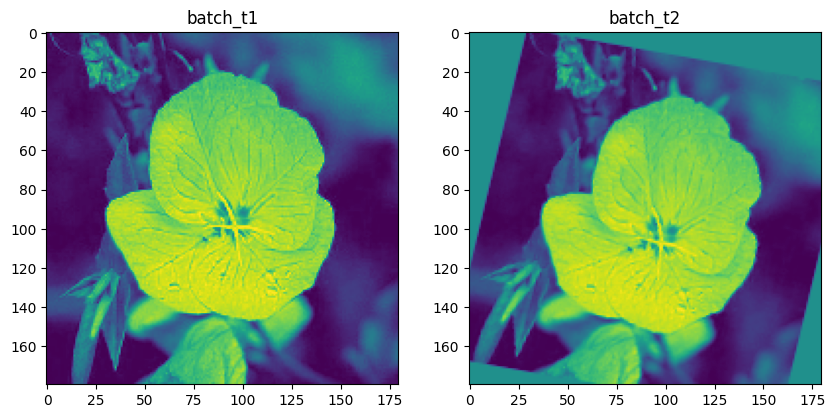

mini_dataloader  torch.Size([12, 2, 41, 41]) torch.Size([1, 3, 12])


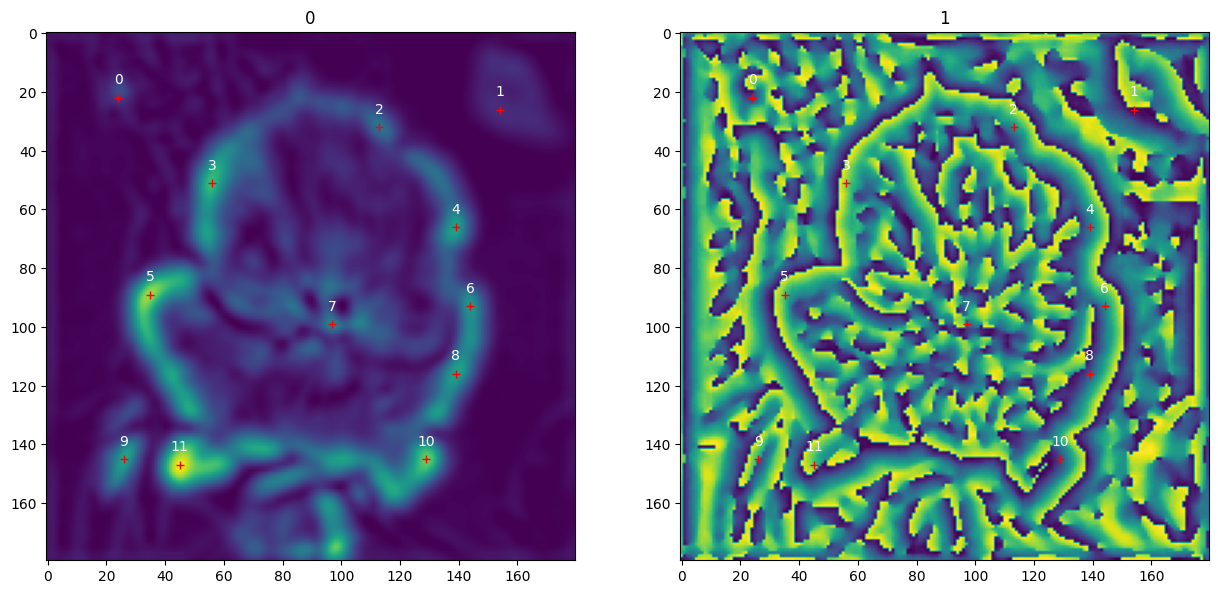

mini_dataloader  torch.Size([11, 2, 41, 41]) torch.Size([1, 11, 2])


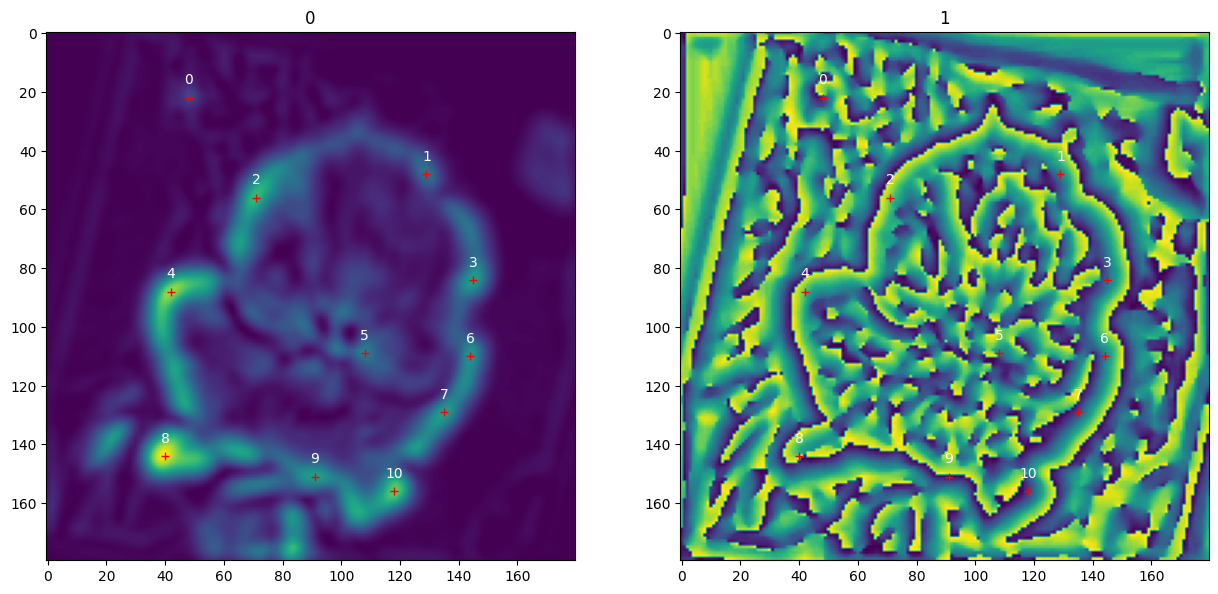

In [71]:
args.nms_size = 30

img_batch, labels =batch
print(len(img_batch),labels) #4

batch_t1 =(img_batch[:1],labels[:1])
img_batch1, labels1 =batch_t1
print(len(img_batch1),labels1) #1

#rotaciona batch_t1
img_batch2 = random_transform(img_batch1)
batch_t2 = (img_batch2,labels1)

plot_pair_image(img_batch1[0,0],img_batch2[0,0],'batch_t1','batch_t2')

#find single point of batch_t2 and batch_t1
feature_t1,orien_t1 = predict_single_points(single_point_model,batch_t1)
batch_result_t1,coords_t1 = extract_features_with_box(feature_t1,orien_t1)
mini_dataloader_t1 = concatenate_mini_batches_feat_orien(batch_result_t1)
points_t1 = coords_t1[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t1.shape,coords_t1.shape)

imshow2(feature_t1[0,0].cpu().detach(),orien_t1[0,0].cpu().detach(),coords_t1[0,:,:17])

feature_t2,orien_t2 = predict_single_points(single_point_model,batch_t2)
batch_result_t2,coords_t2 = extract_features_with_box(feature_t2,orien_t2)
mini_dataloader_t2 = concatenate_mini_batches_feat_orien(batch_result_t2)
points_t2 = coords_t2[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t2.shape,points_t2.shape)
imshow2(feature_t2[0,0].cpu().detach(),orien_t2[0,0].cpu().detach(),coords_t2[0,:,:17])

[(0, 0), (1, 5), (2, 3), (3, 10), (4, 2), (5, 7), (6, 2), (7, 9), (8, 9), (9, 4), (10, 3), (11, 6)]
matching pair  [[ 0  0]
 [ 1  5]
 [ 2  3]
 [ 3 10]
 [ 4  2]
 [ 5  7]
 [ 6  2]
 [ 7  9]
 [ 8  9]
 [ 9  4]
 [10  3]
 [11  6]]
matching pair  torch.Size([12, 2, 41, 41]) torch.Size([12, 2, 41, 41])


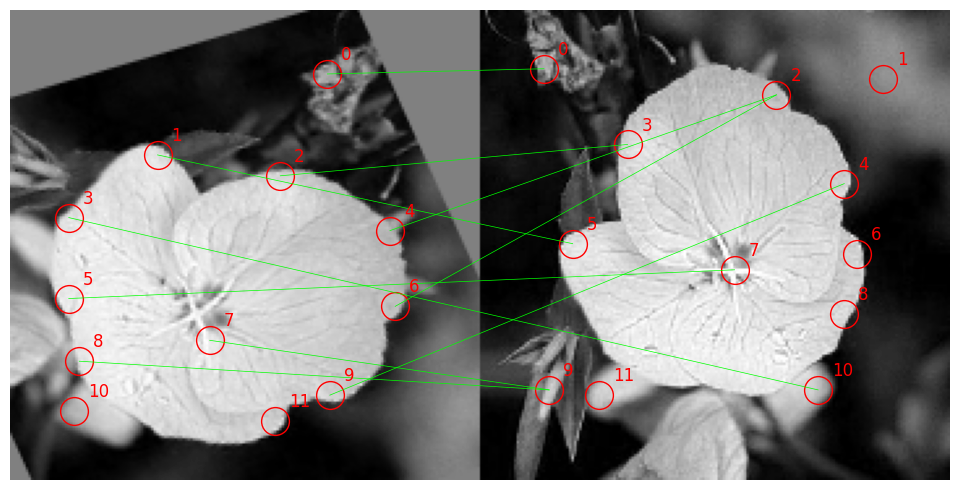

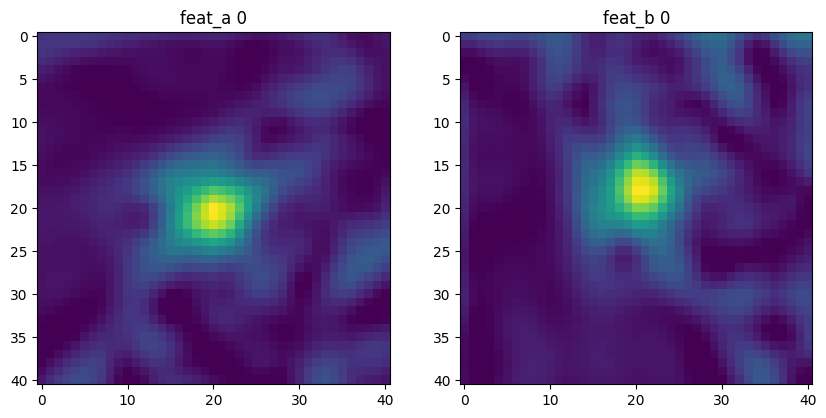

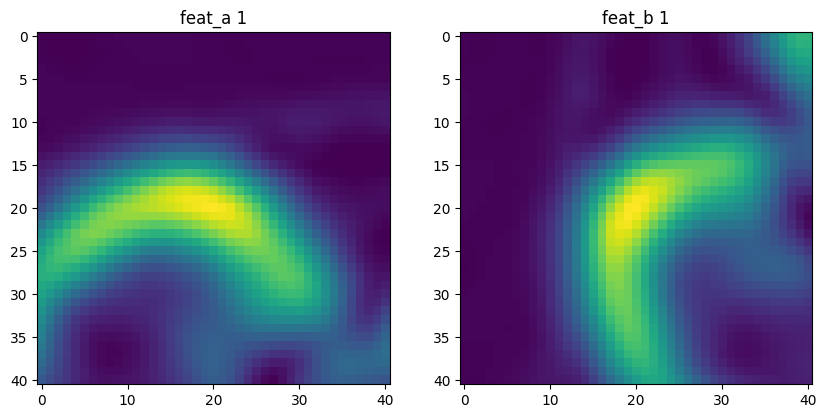

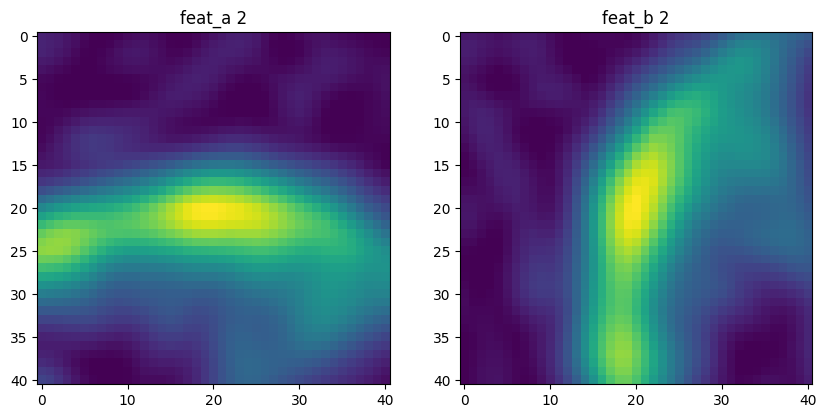

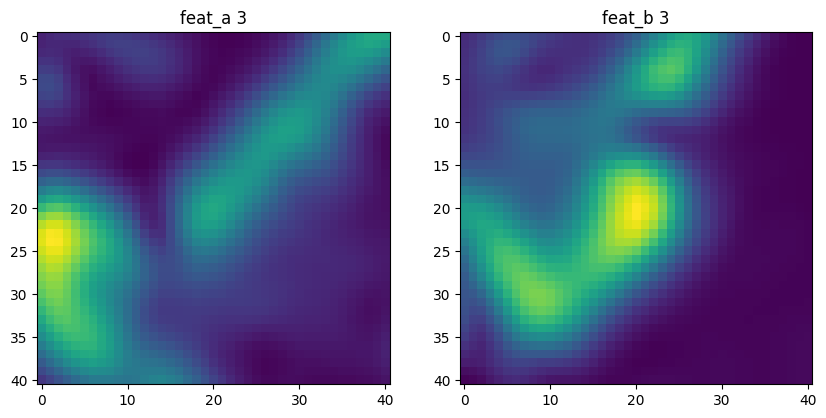

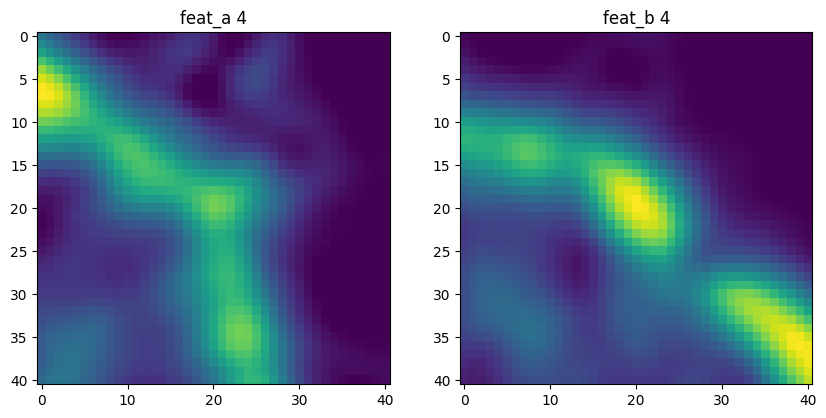

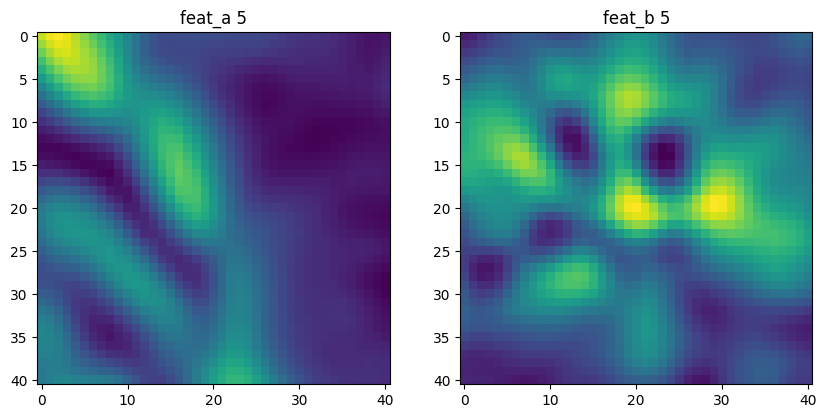

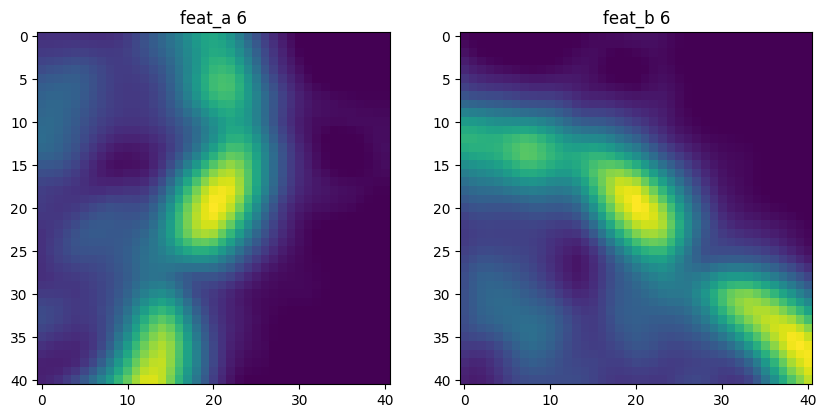

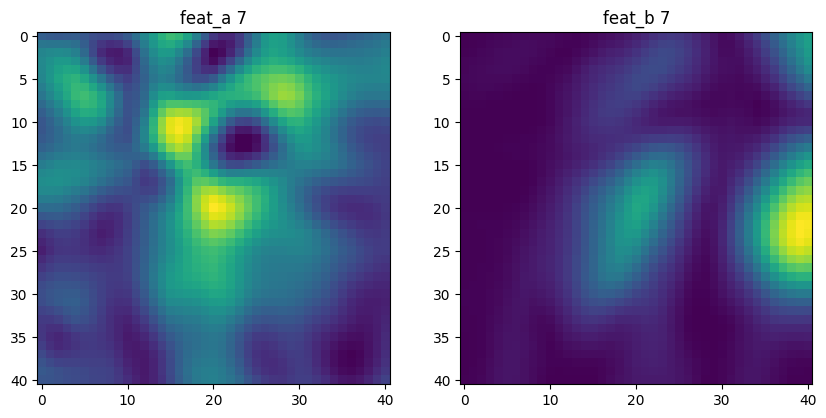

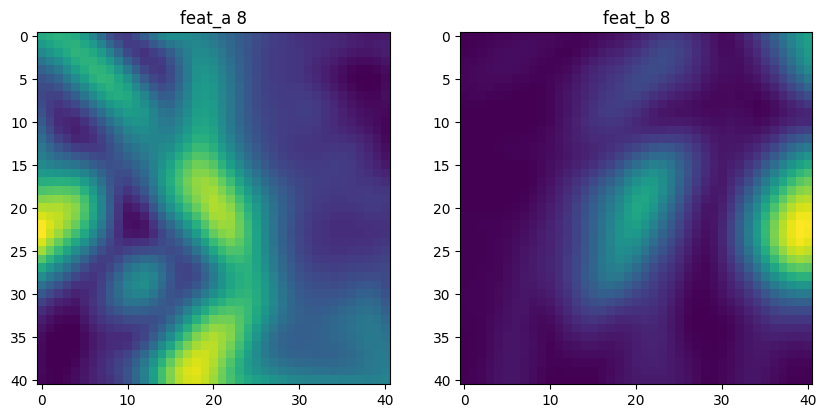

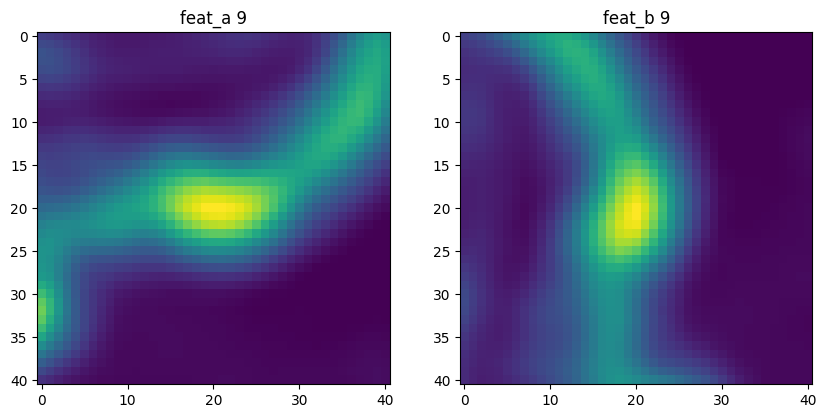

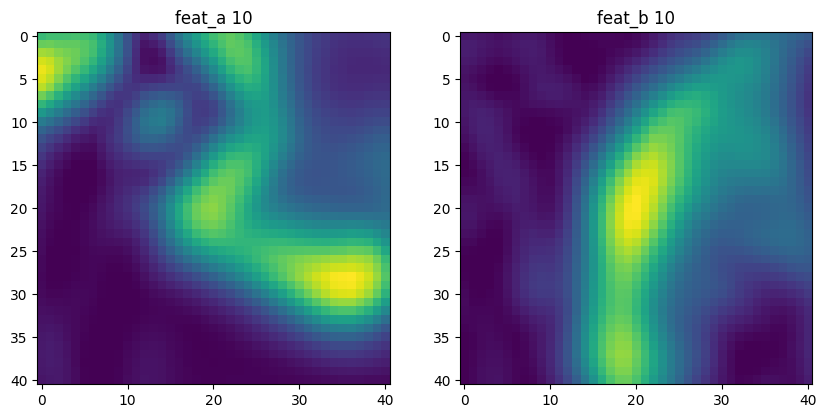

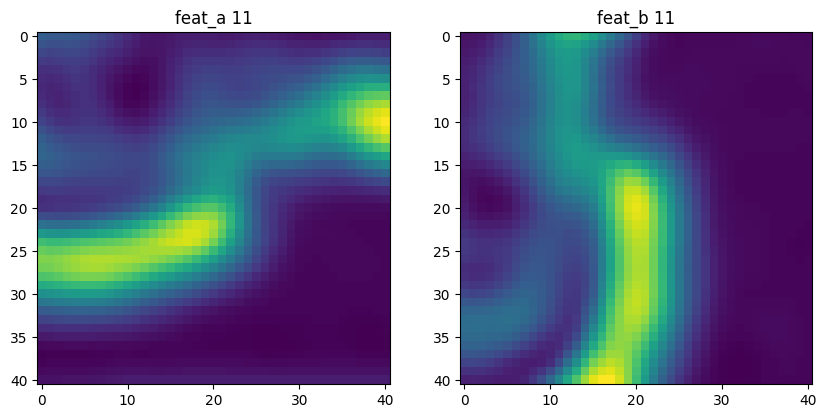

In [68]:



matching_results = matching_single_points(mini_dataloader_t1, mini_dataloader_t2,apply_random_transform=False)

print('matching pair ',matching_results)
print('matching pair ',mini_dataloader_t1.shape,mini_dataloader_t2.shape)
plot_matches_keypoints(img_batch2[0,0], points_t2[0], img_batch1[0,0], points_t1[0],matching_results[:10])
for i in range(matching_results.shape[0]):
    x,y =matching_results[i]
    plot_pair_image(mini_dataloader_t2[x,0],mini_dataloader_t1[y,0],'feat_a {}'.format(i),'feat_b {}'.format(i))

In [61]:
import torch
import kornia.augmentation as K


# Criando uma sequência de transformações
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10),
    data_keys = ['input', 'keypoints']  # Especificando as chaves de dados
)
# Criando uma imagem de exemplo e coordenadas correspondentes
input_image = img_batch1
keypoints = torch.tensor([[[40, 50], [95, 100], [130, 130]]], dtype=torch.float32)


# Aplicando o aumento de dados nas imagens e coordenadas
augmented_image,augmented_keypoints = transformations(input_image, keypoints)

print(keypoints.shape,augmented_keypoints.shape)
print(keypoints,augmented_keypoints)
# Fazer array de matches entre arrays de coordenadas e coordenadas aumentadas
matching_results =[[i, i] for i in range(keypoints.shape[1])]


torch.Size([1, 3, 2]) torch.Size([1, 3, 2])
tensor([[[ 40.,  50.],
         [ 95., 100.],
         [130., 130.]]]) tensor([[[ 37.5117,  78.8265],
         [107.1600,  93.4109],
         [150.6502, 100.9655]]])


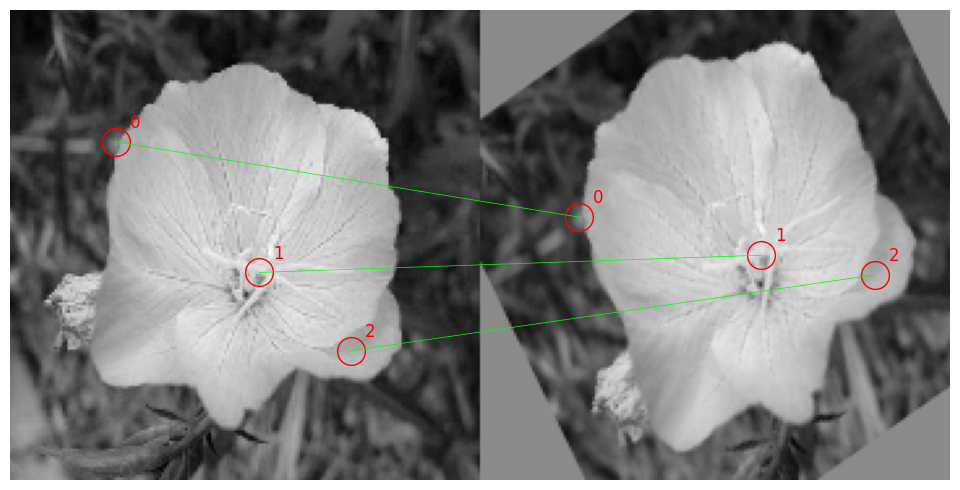

In [62]:


plot_matches_keypoints(input_image[0,0], keypoints[0], augmented_image[0,0], augmented_keypoints[0], matching_results[:10])